## Package loading

In [2]:
package_loader <- function(package_list){
    installed_packages <- packages %in% rownames(installed.packages())
    if (any(installed_packages == FALSE)) {
        warning(paste('Missing package:',packages[!installed_packages]))
    }
    suppressMessages(invisible(lapply(packages[installed_packages], library, character.only = TRUE)))
}


In [3]:
packages <- c('ggplot2','tidyverse','reshape2','matrixStats','ggrepel','DESeq2','RColorBrewer','viridis','heatmaply','plotly','htmlwidgets','hash')
package_loader(packages)

## Variables 

In [ ]:
file_name = "HLB3055_rawCounts.txt"
samp_loc = 'HLB3055_samplesheet.csv'
ref_group = c("7","8","9")

## Importing data

In [5]:
data <- read.table(file = file_name, header = TRUE)
norm_cts <- data.frame(data[,-1])
rownames(norm_cts) <- data$Symbol

In [6]:
samp_dat <- read_csv(samp_loc)
rownames(samp_dat) <- samp_dat[['Sample_ID']] 

Rows: 9 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample_Name, Calibration_Sample, Input_Control
dbl (1): Group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
samp2 <- data.frame(samp_dat[,-1])
rownames(samp2) <- samp_dat$Sample_Name
samp2$Group <- as.character(samp2$Group)

## Setting up DeSeq2

In [172]:
dds_list = list()
for(i in ref_group) {
    
    dds <- DESeqDataSetFromMatrix(countData = norm_cts,
                                  colData = samp2,
                                  design= ~ Group)
    dds$Group <- relevel(dds$Group, ref = i)
    dds <- dds[ rowSums(counts(dds)) > 0, ]
    
    nam <- paste("dds",i,sep="")
    assign(nam, DESeq(dds))
#     lst[[length(lst)+1]] 
#     newlist <- list(oldlist, list(someobj))

    dds_list= append(dds_list,nam)
}

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Need to initialize the coefficients list here

In [173]:
dds_list

[[1]]
[1] "dds7"

[[2]]
[1] "dds8"

[[3]]
[1] "dds9"

In [174]:
resultsNames(dds7)
resultsNames(dds8)
resultsNames(dds9)

[1] "Intercept"    "Group_8_vs_7" "Group_9_vs_7"

[1] "Intercept"    "Group_7_vs_8" "Group_9_vs_8"

[1] "Intercept"    "Group_7_vs_9" "Group_8_vs_9"

In [175]:
subset_dict = list()
subset_dict[['Group_8_vs_7']] <- c(1:6)
subset_dict[['Group_9_vs_7']] <- c(1:3,7:9)
subset_dict[['Group_7_vs_9']] <- c(1:3,7:9)
subset_dict[['Group_8_vs_9']] <- c(4:9)
subset_dict[['Group_7_vs_8']] <- c(1:6)
subset_dict[['Group_9_vs_8']] <- c(4:9)

In [176]:
coef_dict = list()
coef_dict[['Group_8_vs_7']] <- dds7
coef_dict[['Group_9_vs_7']] <- dds7
coef_dict[['Group_7_vs_9']] <- dds9
coef_dict[['Group_8_vs_9']] <- dds9
coef_dict[['Group_7_vs_8']] <- dds8
coef_dict[['Group_9_vs_8']] <- dds8

In [177]:
comp_list = c('Group_8_vs_7','Group_9_vs_7','Group_7_vs_9','Group_8_vs_9','Group_7_vs_8','Group_9_vs_8')

## Generating matrices for heatmaps

In [34]:
library(repr)

In [38]:
p1 <- heatmaply(scale(mm), k_col = 2) 
htmlwidgets::saveWidget(as_widget(p1),"deheatmaply_all.html")

# All genes heatmap

In [140]:
cal_z_score <- function(x){
  (x - mean(x)) / sd(x)
}

mat <- counts(coef_dict[[i]], normalized = T)[rownames(comp),]
    matz <- t(apply(mat, 1, scale))
    colnames(matz)<- rownames(samp2)
    matz <- na.omit(matz)

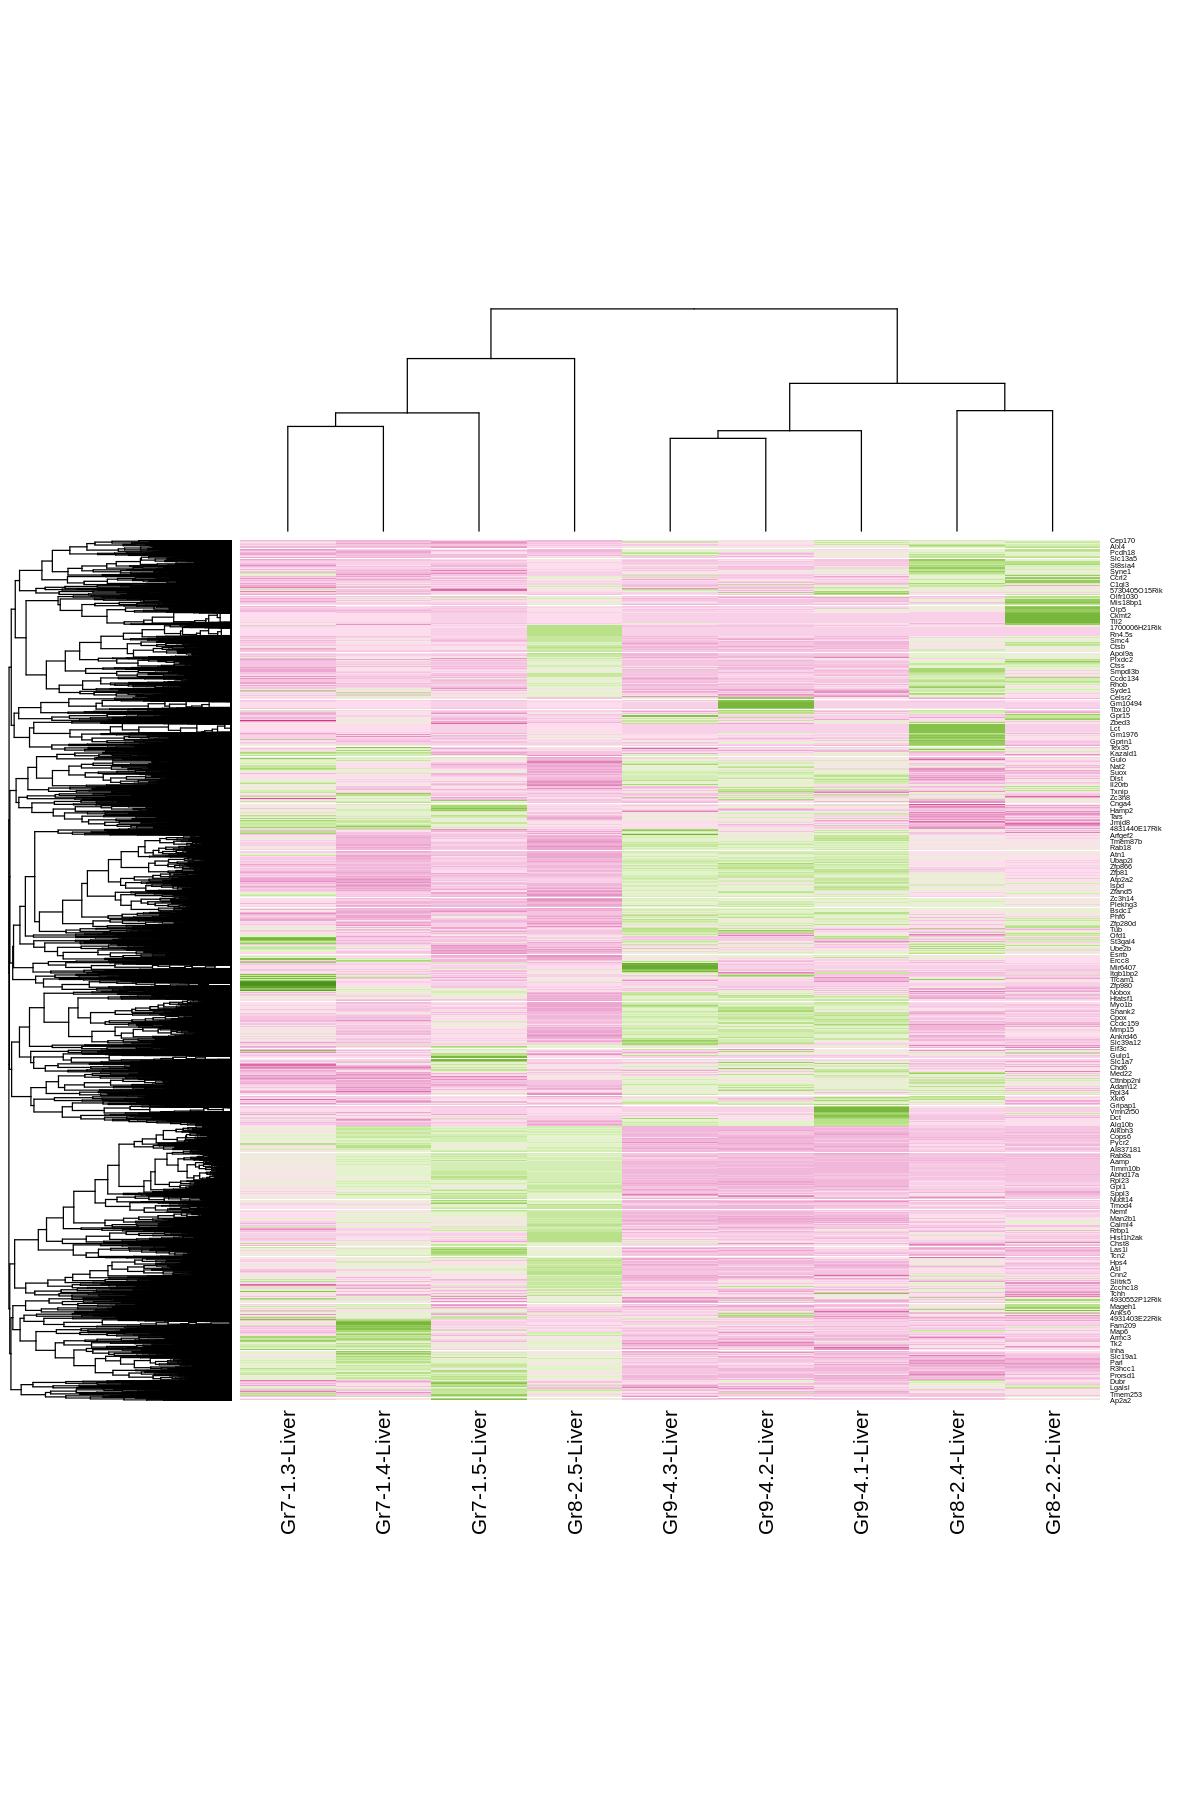

In [92]:
coul <- colorRampPalette(brewer.pal(8, "PiYG"))(25)
options(repr.plot.width=10, repr.plot.height=15)
heatmap(matz, scale="column", col = coul)


In [226]:
options(repr.plot.width=10, repr.plot.height=400)
pheatmap(matz,
#          annotation_row = my_gene_col,
#          annotation_col = my_sample_col,
         cutree_rows = 2,
         cutree_cols = 2,
         main = "All genes")

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): unable to start device 'png'


plot without title

# Subsetting genes by top DE

In [131]:
i = 'Group_8_vs_9'

In [197]:
mat <- counts(coef_dict[[i]], normalized = T)[rownames(comp),]
    matz <- t(apply(mat, 1, scale))
    colnames(matz)<- rownames(samp2)
    matz <- na.omit(matz)
    names <- rownames(matz)
    matz <- cbind(names,matz)
    
    matzdf <- as.data.frame(matz)
    matzf <- matzdf %>%
        filter(names %in% noiglist)
    matzf <- matzf[-1]
    matzf <- mutate_all(matzf, function(x) as.numeric(as.character(x)))
                        
    mm <- as.matrix(matzf)
    mm <- na.omit(mm)


In [107]:
immune_tab <- 'InnateDB_genes.csv'

In [108]:
immune_df <- read_csv(immune_tab)


Rows: 4723 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (16): species, ensembl, name, fullname, synonym, signature, chromName, ...
dbl   (7): id, taxonId, chromStart, chromEnd, chromStrand, nrIntxsValidated,...
lgl   (1): humanOrthologs
date  (1): lastModified

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [116]:
library(stringr)

In [ ]:
ilist <- list()
l <- as.list(immune_df$name)

for (i in l){
    new_element <- str_to_title(i)
    ilist[[length(ilist)+1]]<-new_element}


In [ ]:
newlist <- biglist[!biglist %in% ilist]

# DE genes from 9v7 only

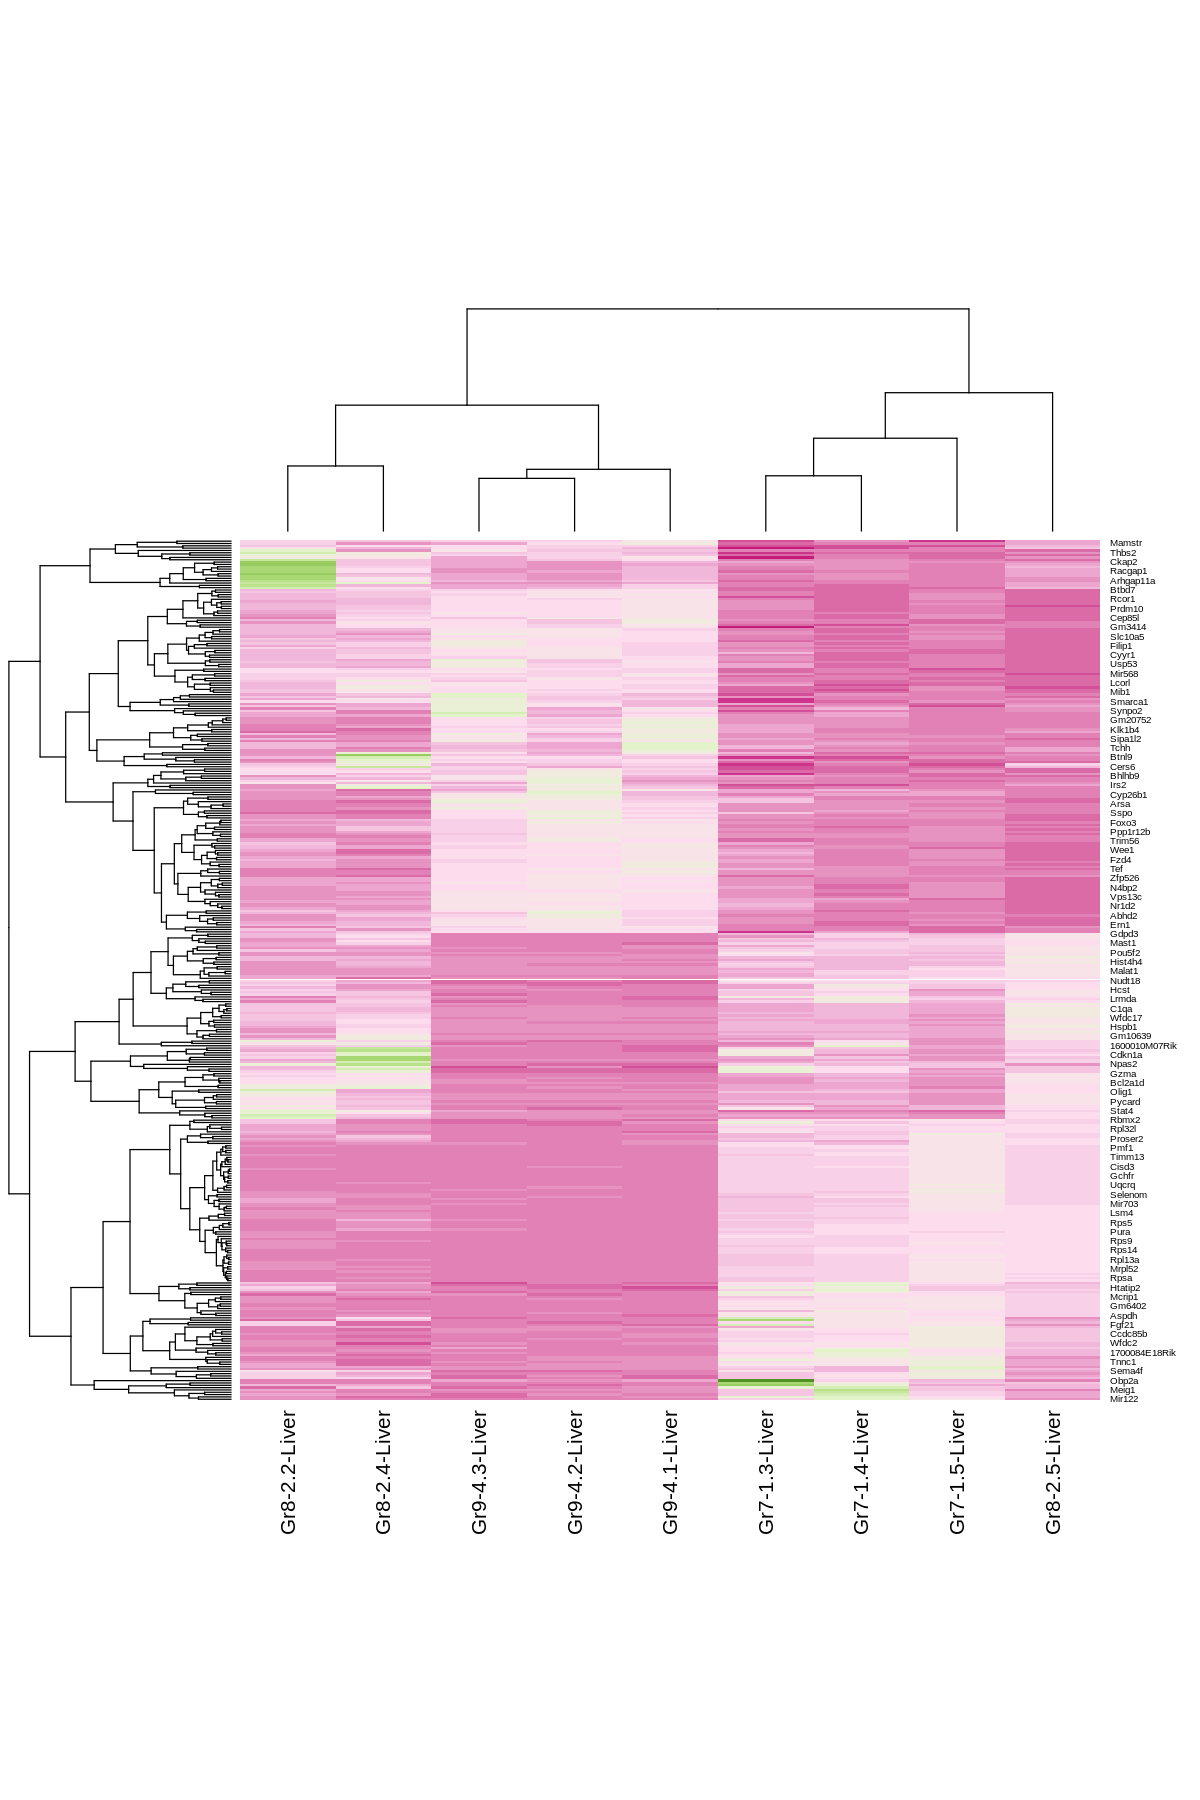

In [195]:
coul <- colorRampPalette(brewer.pal(8, "PiYG"))(25)
options(repr.plot.width=10, repr.plot.height=15)
heatmap(mm, scale="column", col = coul)


# Removed immune related genes

In [139]:
library(pheatmap)

In [ ]:
my_hclust_gene <- hclust(dist(matz), method = "complete")
 
# install if necessary
#install.packages("dendextend")
 
# load package
#library(dendextend)

In [213]:
my_gene_col <- cutree(tree = as.dendrogram(my_hclust_gene), k = 2)

In [214]:
my_gene_col <- data.frame(cluster = ifelse(test = my_gene_col == 1, yes = "cluster 1", no = "cluster 2"))

In [222]:
my_sample_col <- data.frame(sample = rep(c("knockout vehicle", "treated","wildtype"), c(3,3,3)))
row.names(my_sample_col) <- colnames(matz)

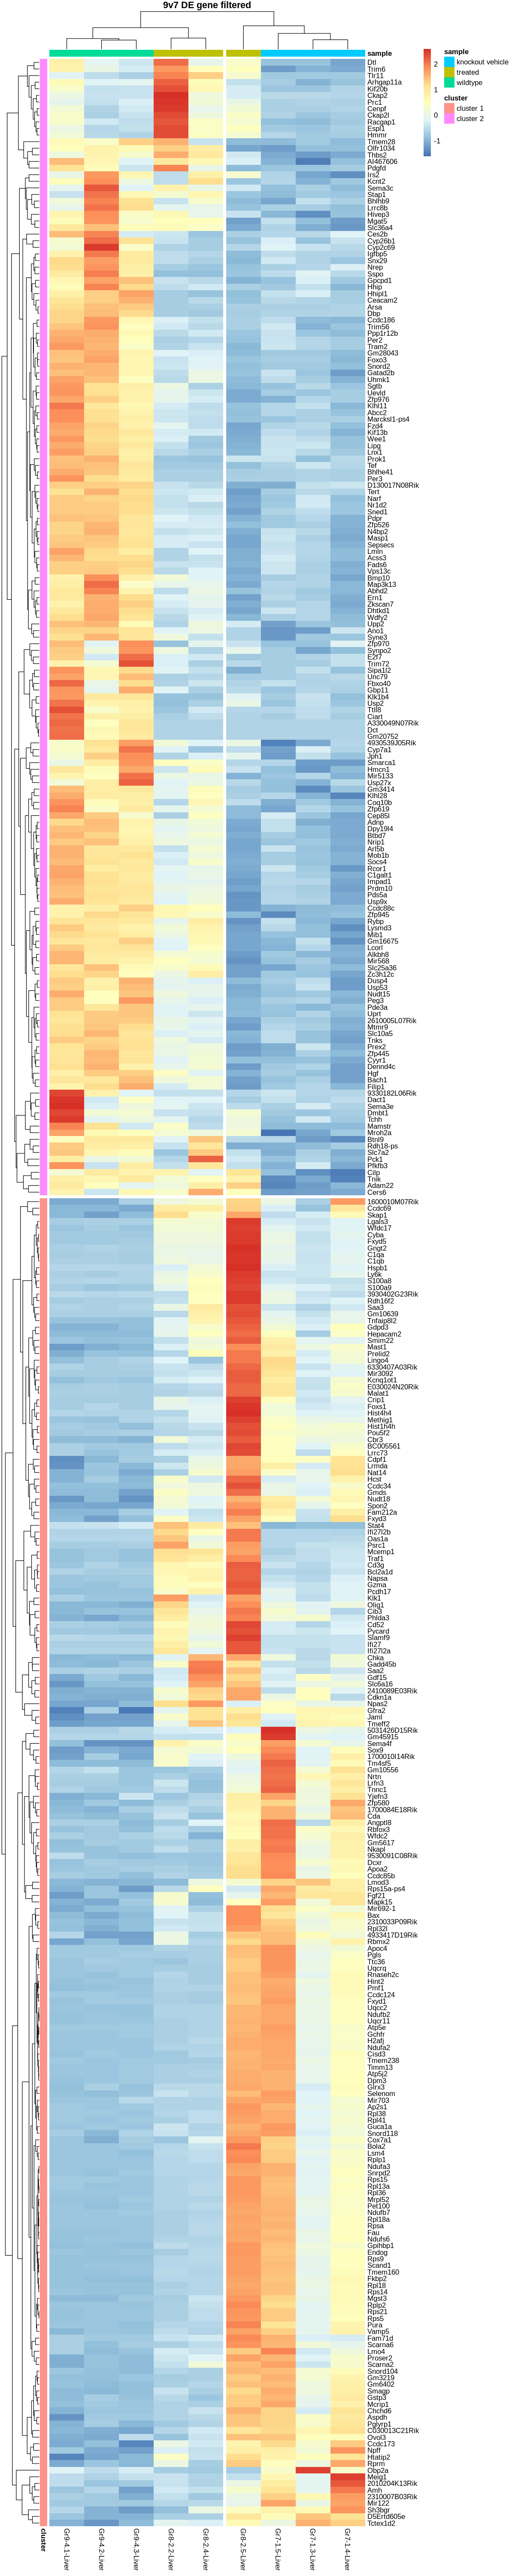

In [210]:
options(repr.plot.width=10, repr.plot.height=50)
pheatmap(mm,
         annotation_row = my_gene_col,
         annotation_col = my_sample_col,
         cutree_rows = 2,
         cutree_cols = 2,
         main = "9v7 DE gene filtered")

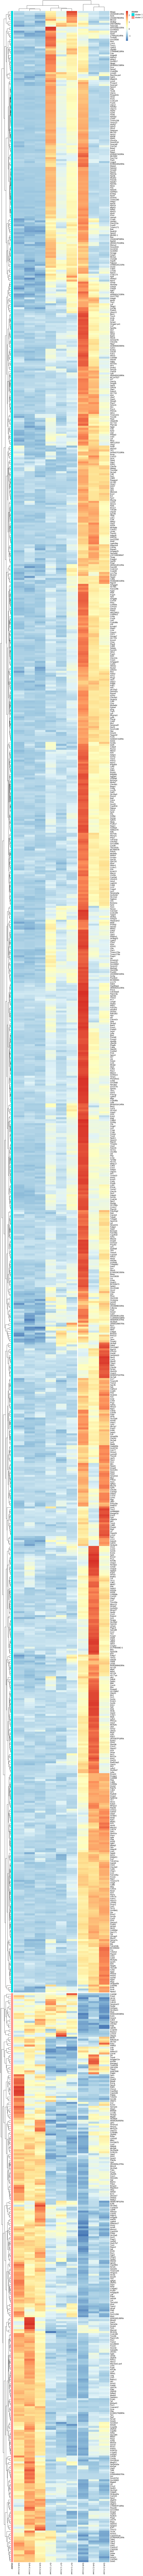

In [167]:
pheatmap(mm,
         annotation_row = my_gene_col,
         cutree_rows = 2,
         cutree_cols = 2)

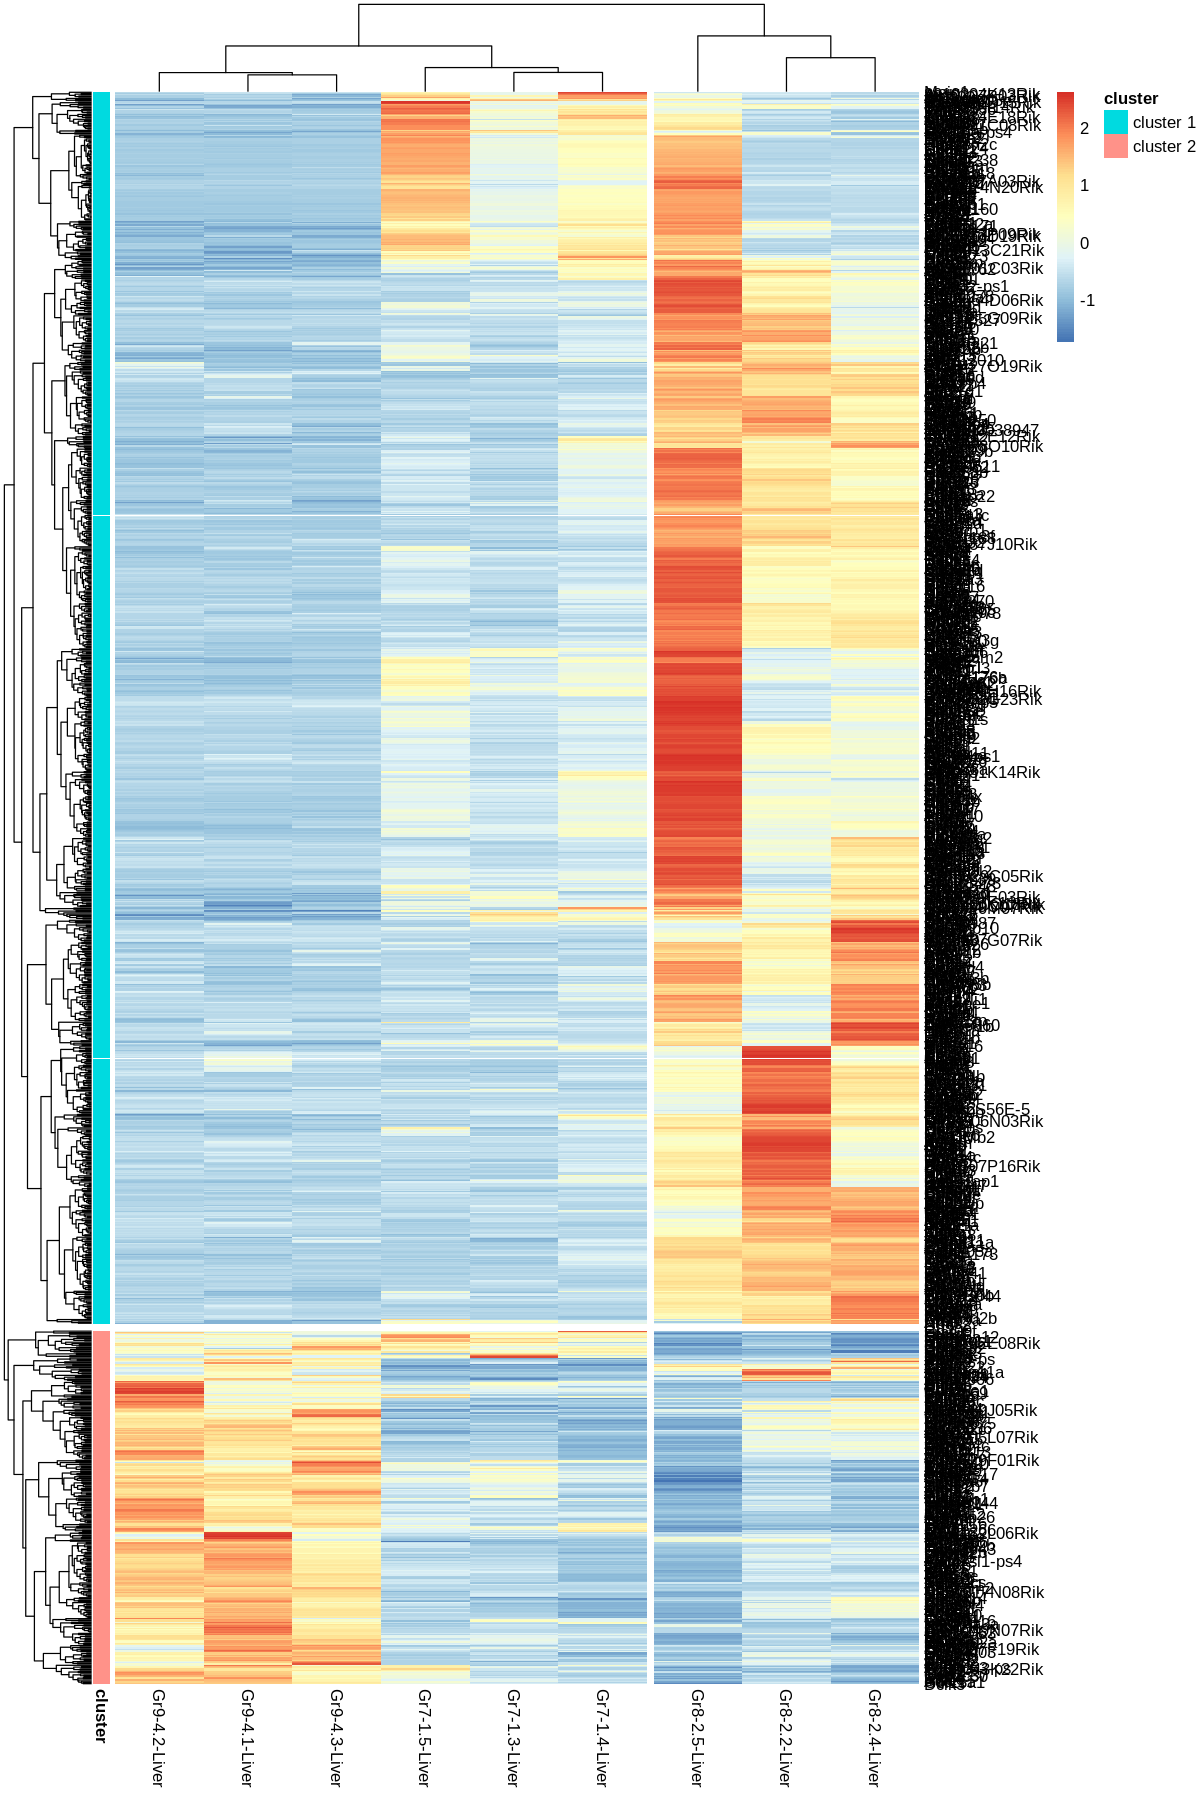

In [170]:
options(repr.plot.width=10, repr.plot.height=15)

pheatmap(mm,
         annotation_row = my_gene_col,
         cutree_rows = 2,
         cutree_cols = 2)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



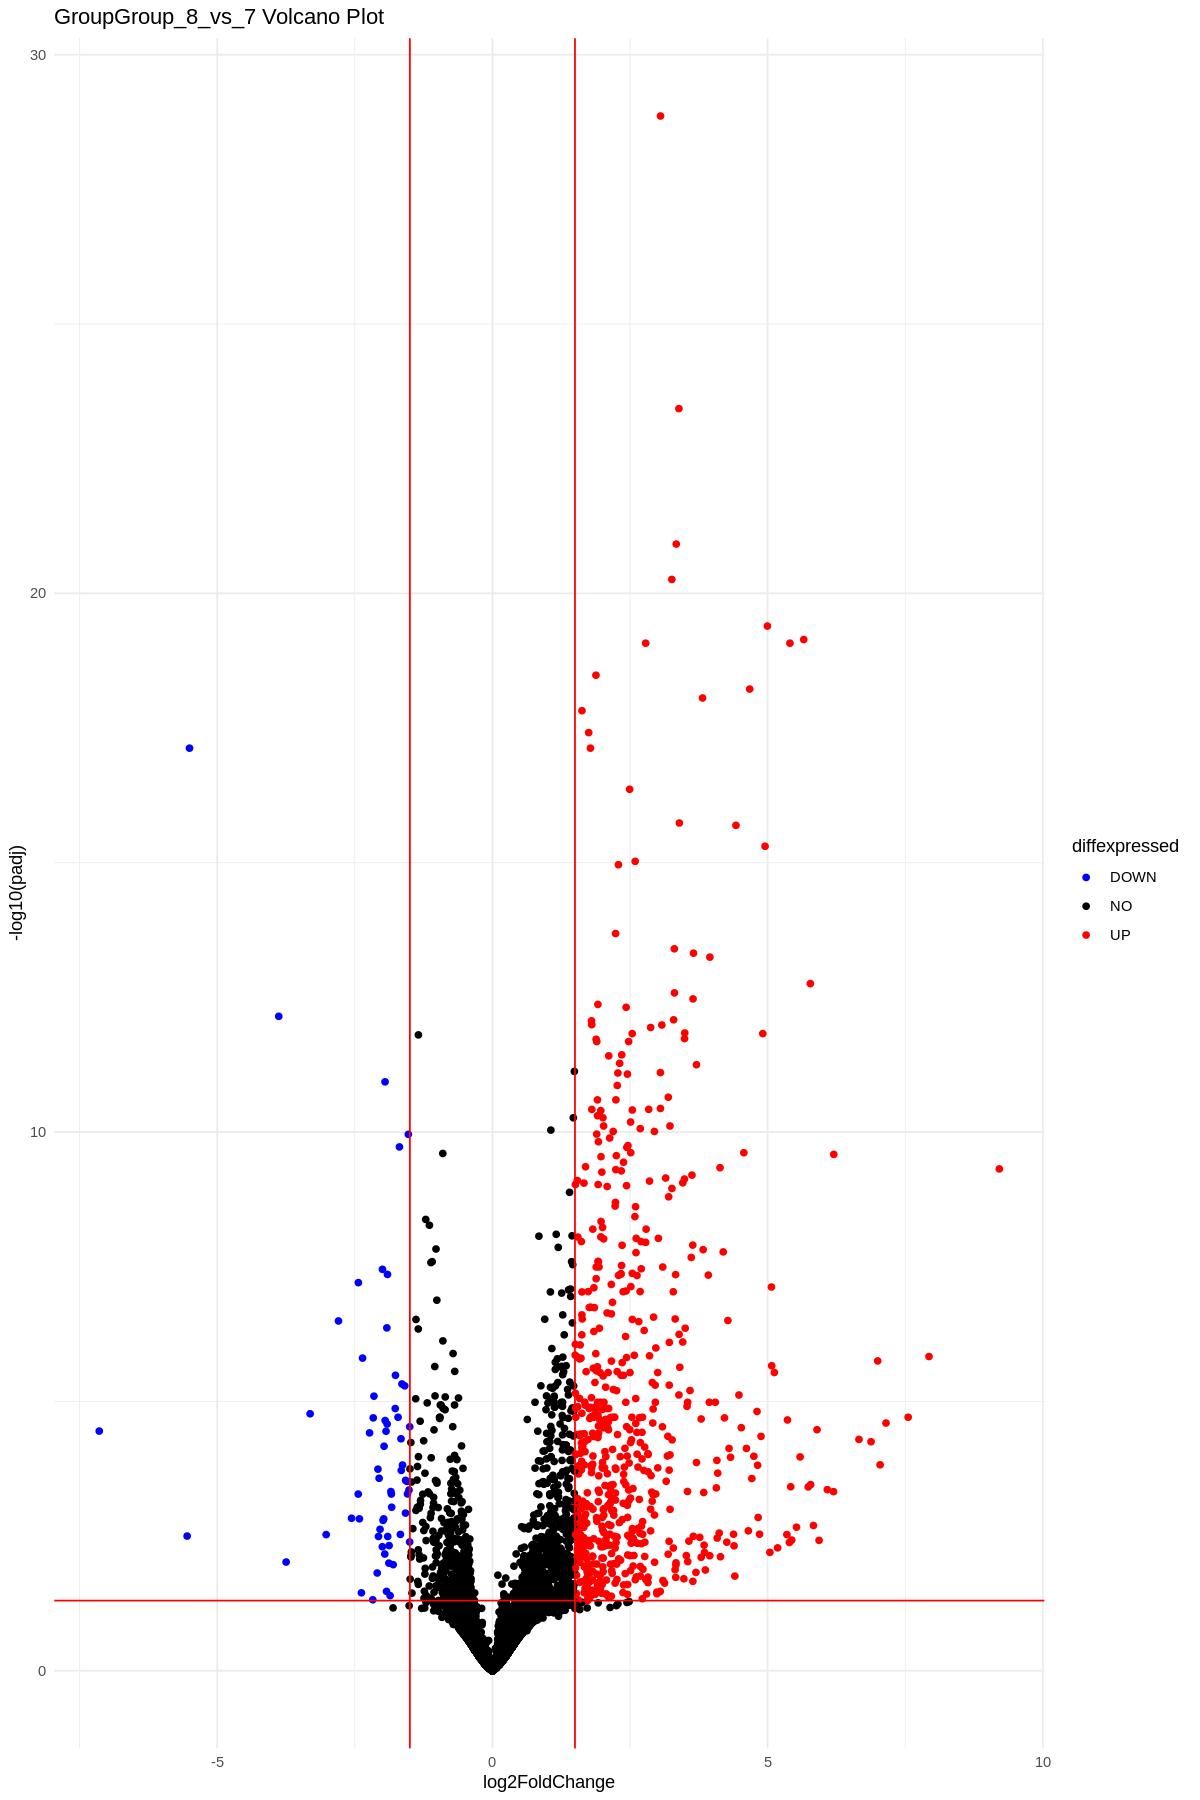

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



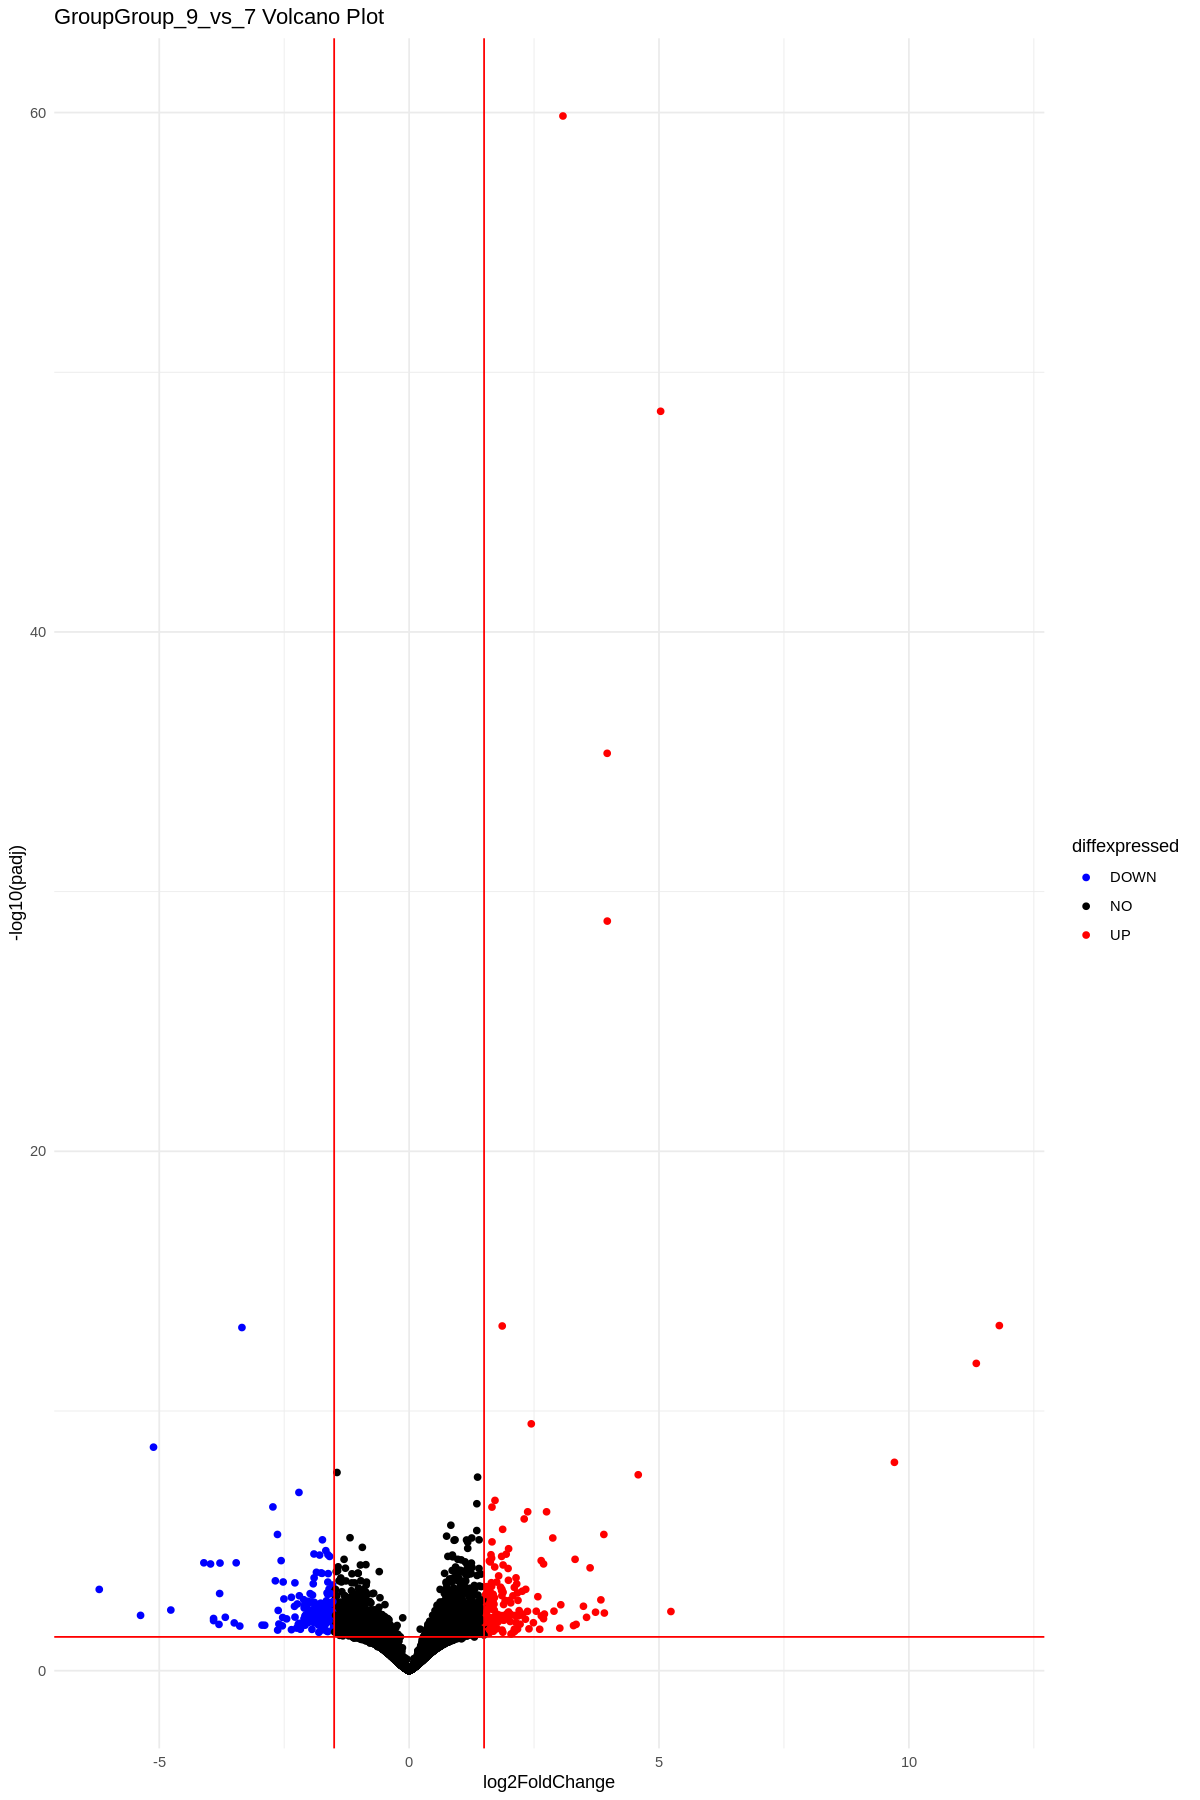

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



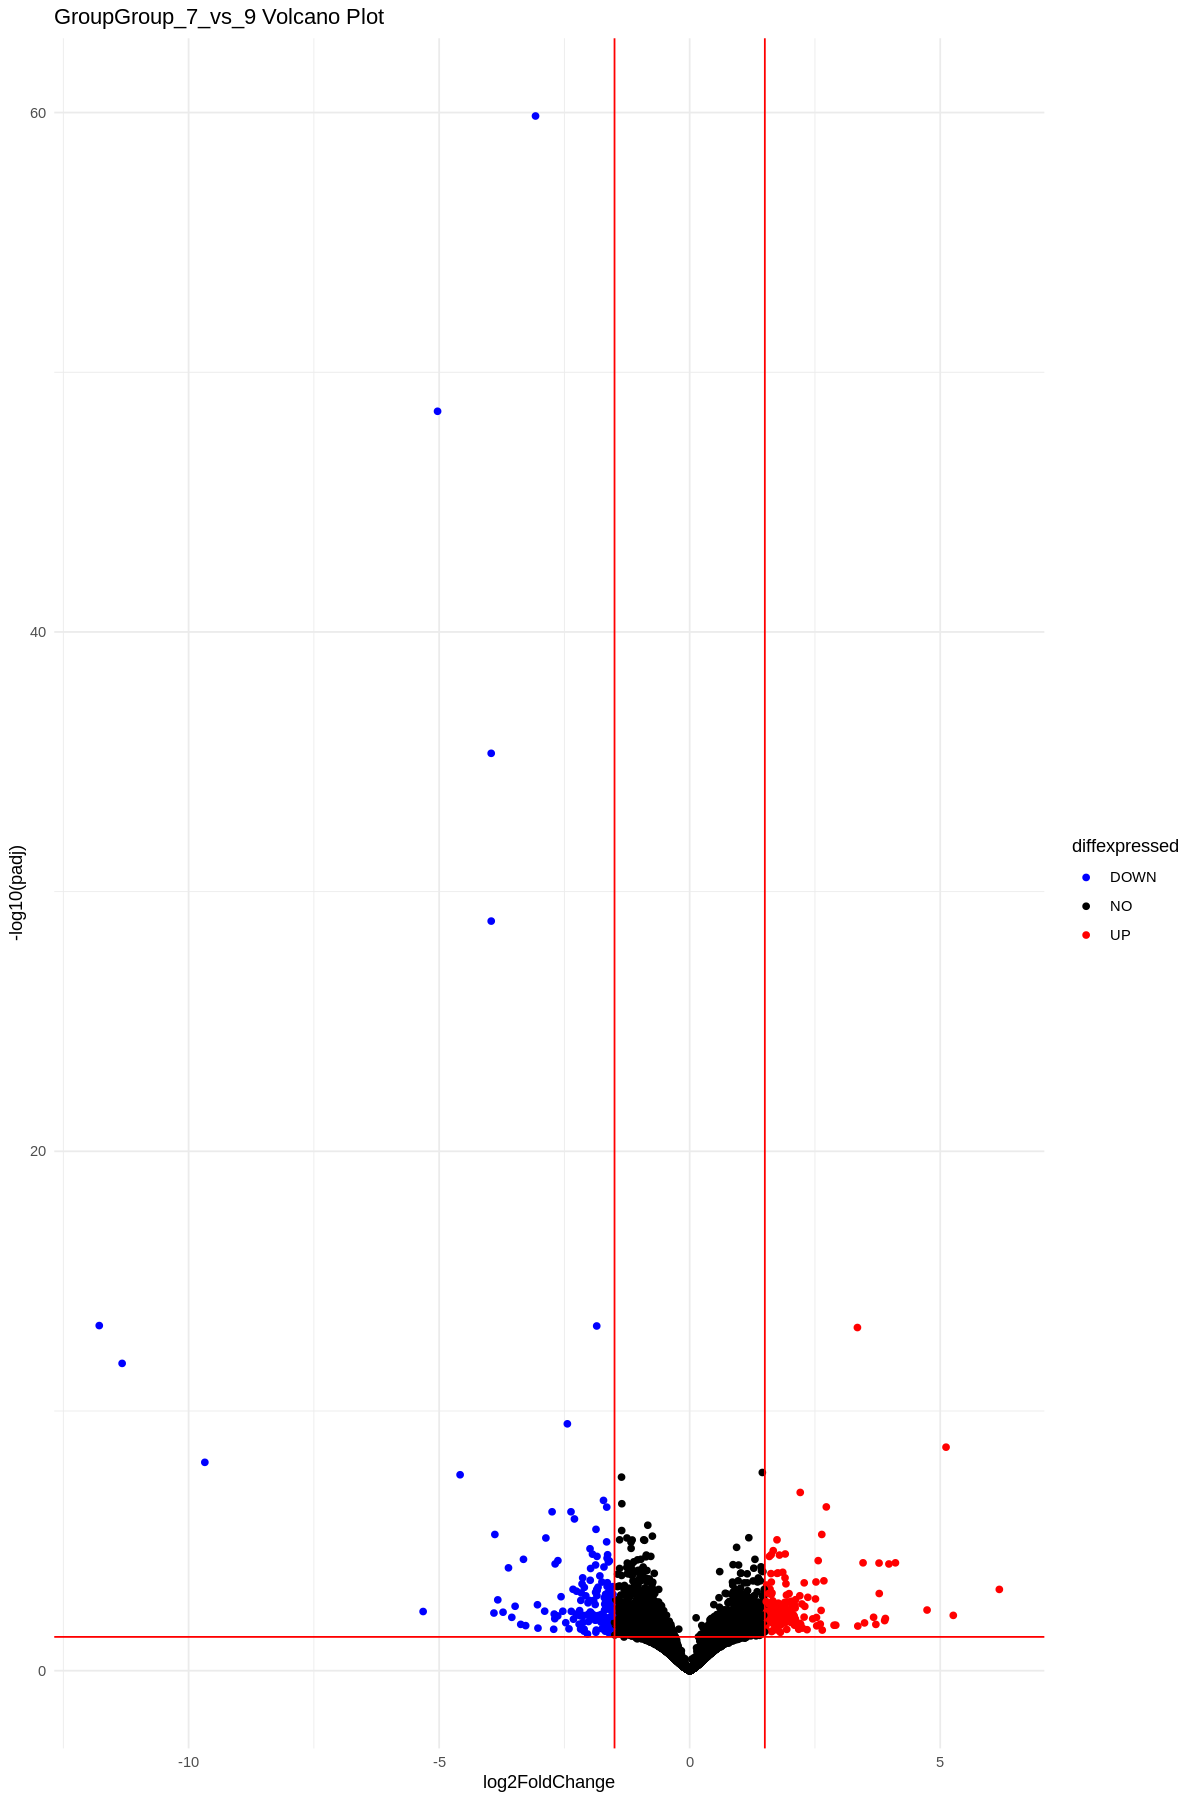

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



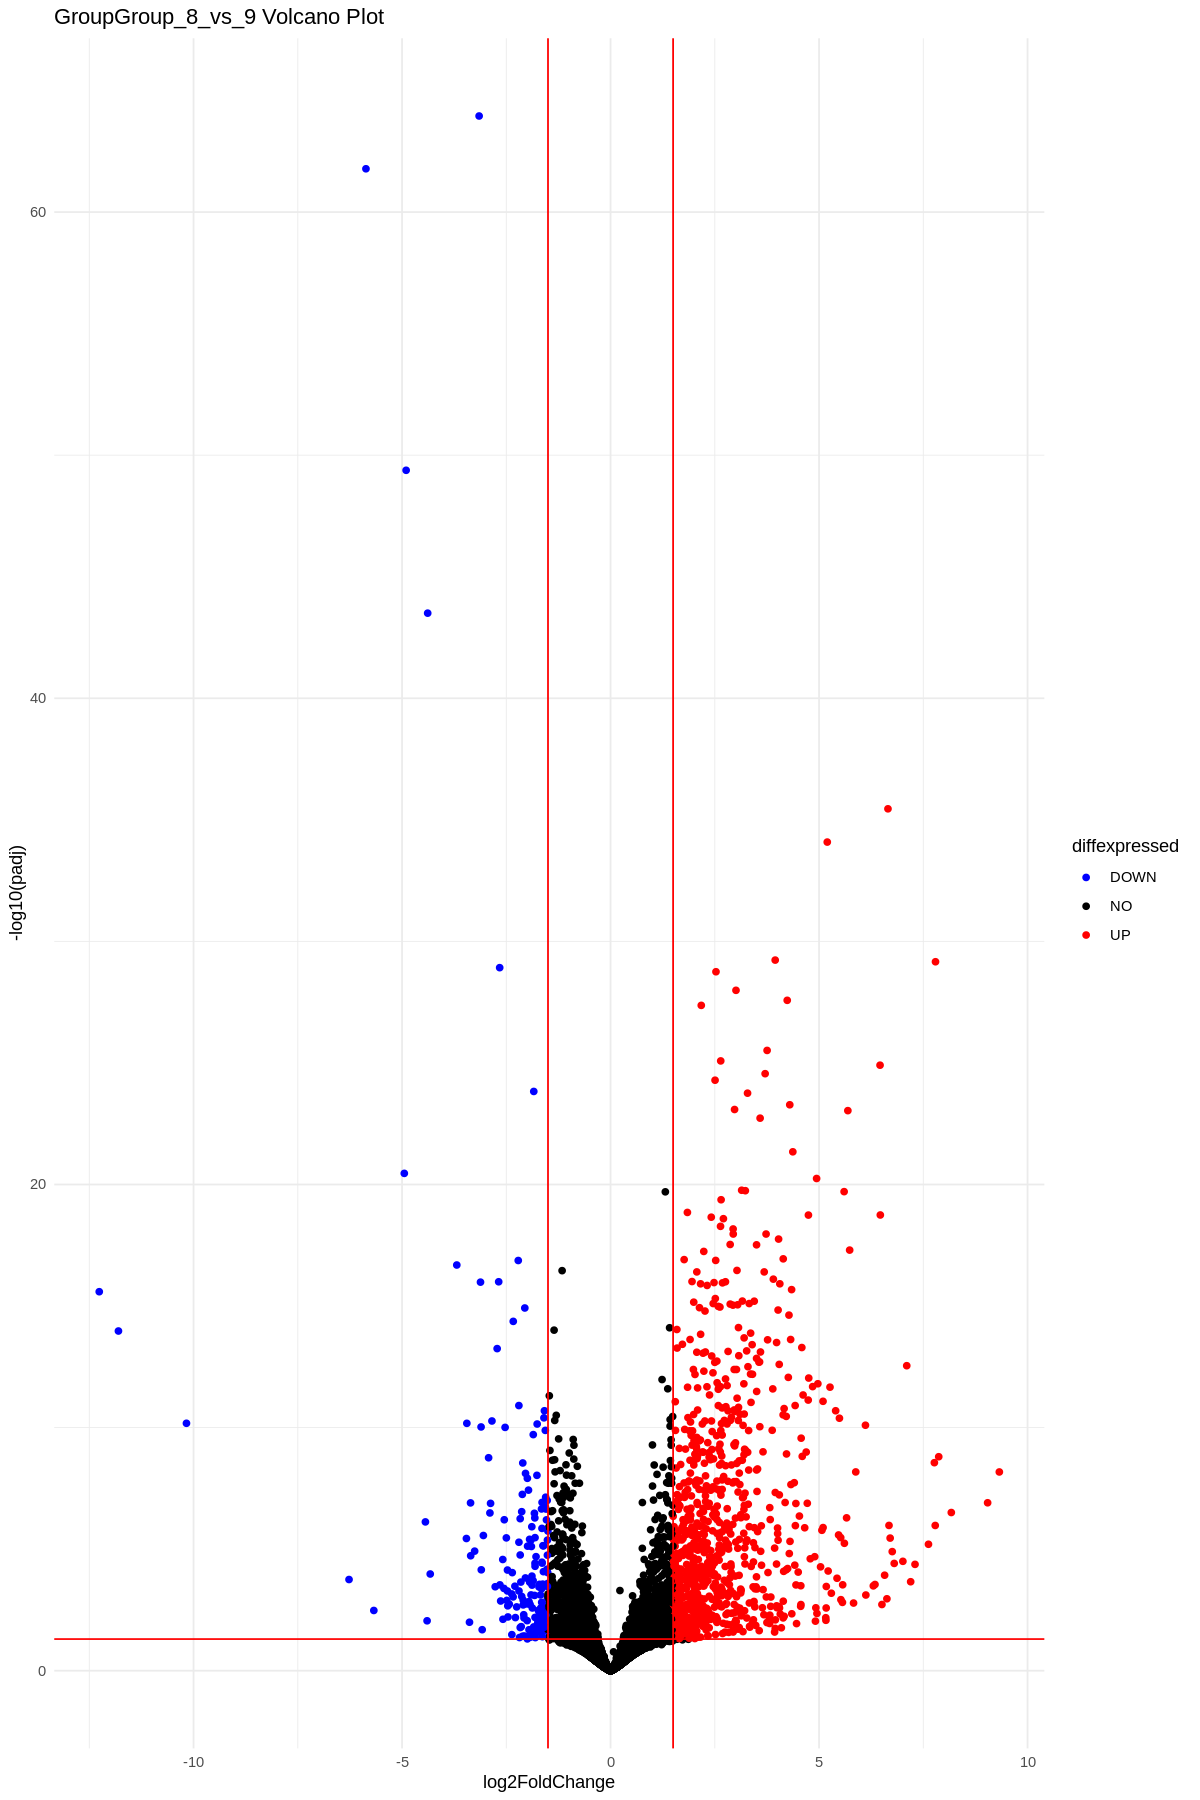

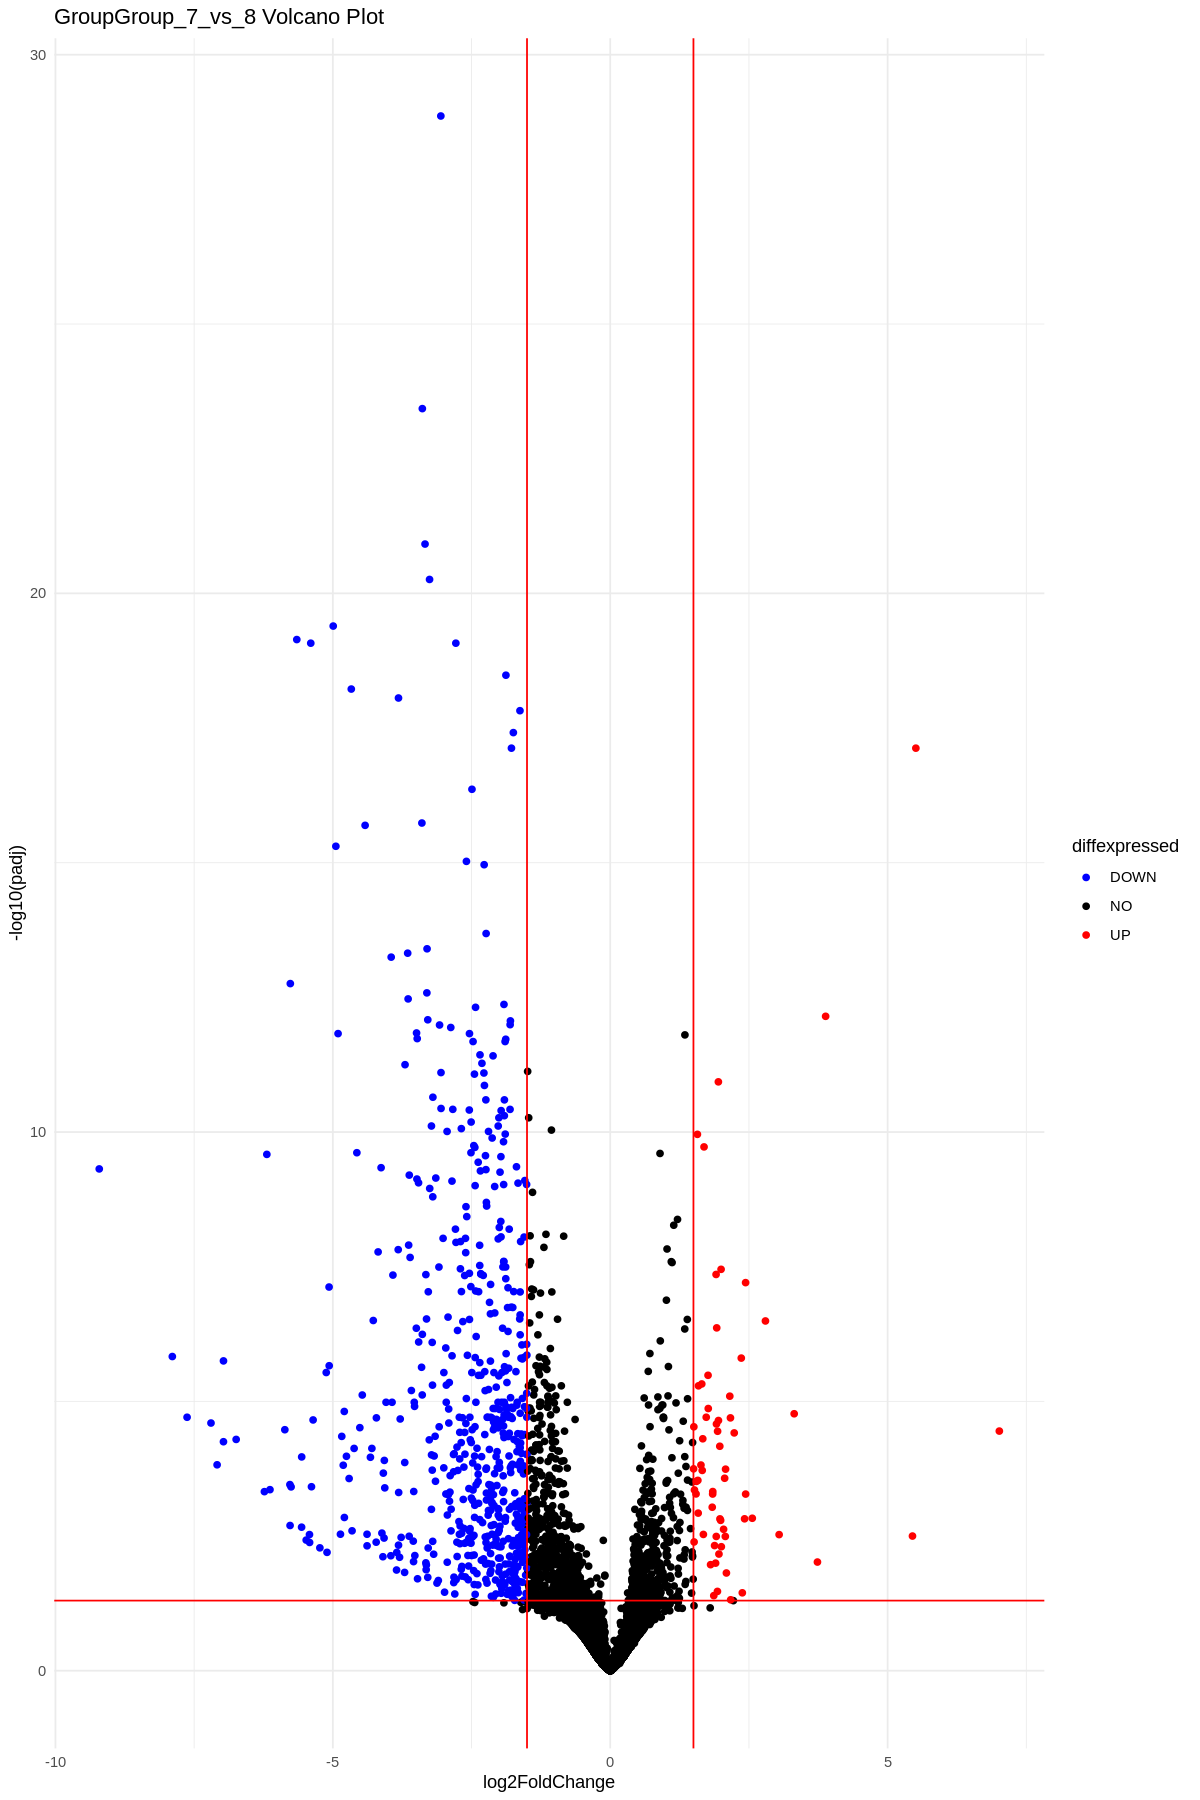

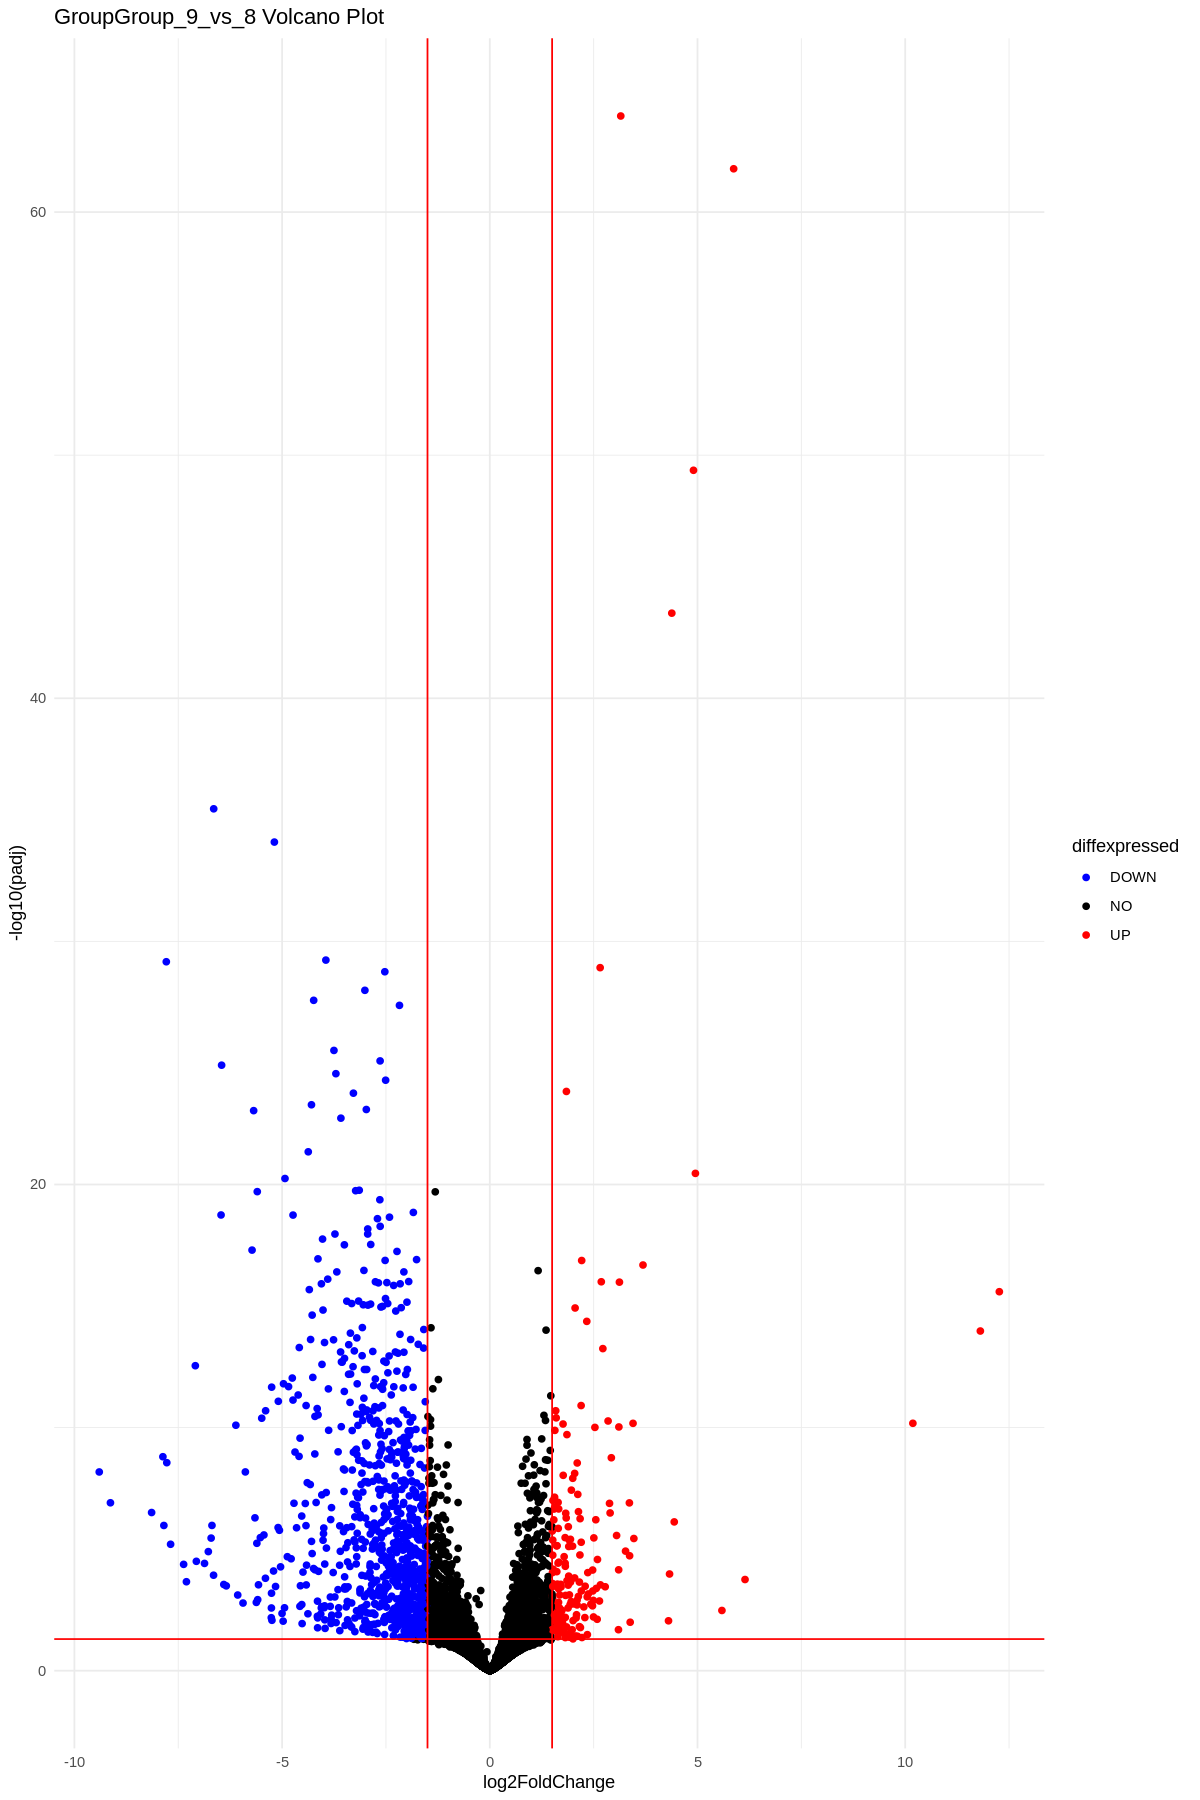

In [178]:
for (i in comp_list) {
    comp <- lfcShrink(coef_dict[[i]], coef=i, type="apeglm")
    comp <-as.data.frame(comp)
    filt_comp <- comp %>%
        filter((log2FoldChange >= 1.5 | log2FoldChange <= -1.5) & padj <= 0.05)
    
    mat <- counts(coef_dict[[i]], normalized = T)[rownames(comp),]
    matz <- t(apply(mat, 1, scale))
    colnames(matz)<- rownames(samp2)
    matz <- na.omit(matz)
    names <- rownames(matz)
    matz <- cbind(names,matz)
    
    matzdf <- as.data.frame(matz)
    matzf <- matzdf %>%
        filter(names %in% row.names(filt_comp))
    matzf <- matzf[-1]
    matzf <- mutate_all(matzf, function(x) as.numeric(as.character(x)))
                        
    mm <- as.matrix(matzf)
    mm <- na.omit(mm)
    mmcomp <- mm[,c(subset_dict[[i]])]
    
    p <- plot_ly(x=colnames(mmcomp), y=rownames(mmcomp), z = mmcomp, type = "heatmap")
    htmlwidgets::saveWidget(as_widget(p), paste("deplot",i,".html",sep = ""))
                        
    p1 <- heatmaply(scale(mmcomp), k_col = 2) 
    htmlwidgets::saveWidget(as_widget(p1), paste("deheatmaply",i,".html",sep = ""))
                        
    volcanocomp <- comp 
    volcanocomp$diffexpressed <- "NO"
    
    volcanocomp$diffexpressed[volcanocomp$log2FoldChange >= 1.5 & volcanocomp$padj < 0.05] <- "UP"
    volcanocomp$diffexpressed[volcanocomp$log2FoldChange <= -1.5 & volcanocomp$padj < 0.05] <- "DOWN"
    volcanocomp <- na.omit(volcanocomp)
                        
    volcanocomp$delabel <- NA
    p2 <- ggplot(data=volcanocomp, aes(x=log2FoldChange, y=-log10(padj), col=diffexpressed)) +
            geom_point() + 
            theme_minimal() +
            scale_color_manual(values=c("blue", "black", "red")) +
            geom_vline(xintercept=c(-1.5, 1.5), col="red") +
            geom_hline(yintercept=-log10(0.05), col="red") + 
            ggtitle(paste("Group",i," Volcano Plot",sep = ""))
    print(p2)
    
    ug <- paste("upgenes_", i, sep = "")
    dg <- paste("downgenes_", i, sep = "")
    assign(ug,volcanocomp[volcanocomp$diffexpressed == 'UP',])
    assign(dg,volcanocomp[volcanocomp$diffexpressed == 'DOWN',])
        
}

## Upregulated and Downregulated genes

In [179]:
for (i in comp_list){
    print(paste("upgenes_", i, sep = ""))
    print(paste("downgenes_", i, sep = ""))
}

[1] "upgenes_Group_8_vs_7"
[1] "downgenes_Group_8_vs_7"
[1] "upgenes_Group_9_vs_7"
[1] "downgenes_Group_9_vs_7"
[1] "upgenes_Group_7_vs_9"
[1] "downgenes_Group_7_vs_9"
[1] "upgenes_Group_8_vs_9"
[1] "downgenes_Group_8_vs_9"
[1] "upgenes_Group_7_vs_8"
[1] "downgenes_Group_7_vs_8"
[1] "upgenes_Group_9_vs_8"
[1] "downgenes_Group_9_vs_8"
